# Problem Session 2

In this problem session we practice our skills with :

* Exploratory Data Analysis
* Simple linear regression
* Multiple linear regression
* k nearest neighbors regression
* kFold cross validation

In [57]:
## We first load in packages we will need
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import sklearn
sns.set_style("whitegrid")

#### 1. Introducing the data

Our data concerns Median house prices for California districts derived from the 1990 census.

This dataset was found on Kaggle.com, <a href="https://www.kaggle.com/datasets/camnugent/california-housing-prices/data">https://www.kaggle.com/datasets/camnugent/california-housing-prices/data</a>.

##### a. 

First load the data for this problem. It is stored in the file `housing.csv` in the `data` folder of the repository. After loading the data look at the first five rows of the dataset. Then run `housing.info()`.  Are there any missing values?

In [58]:
housing = pd.read_csv('housing.csv')
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  object 
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(8), object(2)
memory usage: 1.6+ MB


Yes, `total_bedrooms` has some missing values.

##### b. 

There are future lecture notebooks that cover ways to <i>impute</i> missing values, but for this notebook you will simply remove the missing values. 

Use `dropna`, <a href="https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.dropna.html">https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.dropna.html</a> to get a version of the data set that has had the missing values removed.


In [59]:
housing = housing.dropna()

##### c.

The column `median_house_value` currently contains strings instead of a floats.  Before doing any modeling you will have to clean the data a little bit.

Write a function `clean_column` which passes the indicated tests. 

Then use `.apply`, <a href="https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html">https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html</a> to apply clean_column to `median_house_value`.

In [60]:
# Define your function below
def clean_column(s) -> float|None:
    if type(s) != str:
        return None
    else:
        s = s[1:-2]
        s = s.replace(',', '')
        # print(s)
        return float(s)

assert clean_column('$432,425.0') == 432425.0
assert clean_column('$15,326.0') == 15326.0

In [61]:
# Use the function to clean the median_house_value column
housing['median_house_value'] = housing['median_house_value'].apply(clean_column)

### Predictive Model

In the next couple of problem session notebooks you will build a series of models to predict the sale price of a given vehicle.

#### 2. Train test split

The first step in predictive modeling is performing a train test split. Perform a train test split on these data, setting aside $20\%$ of the data as a test set. Choose a `random_state` so your results are reproducible.

As a refresher you can use `sklearn`'s `train_test_split` function: 

<a href="https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html">https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html</a>.

In [62]:
# use random_state = 216 if you want the same split as the complete notebook
# X = housing.loc[ : , housing.columns != 'median_house_value']
# y = housing['median_house_value']
housing_train, housing_test = sklearn.model_selection.train_test_split(housing, test_size=0.2, random_state=518)

#### 3. Exploratory data analysis (EDA)

After the train test split we can work on some exploratory data analysis. Here is where we start to look at the data and see if we can generate any modeling ideas or hypotheses. You will make a series of plots and learn a modeling trick that should improve any models we make.

##### a. 

Use `seaborn`'s `pairplot`, <a href="https://seaborn.pydata.org/generated/seaborn.pairplot.html">https://seaborn.pydata.org/generated/seaborn.pairplot.html</a> to plot `median_selling_value` against `housing_median_age`, `total_rooms`, `total_bedrooms`, `population`,`households`, and `median_income`. Shell code is provided for you below.

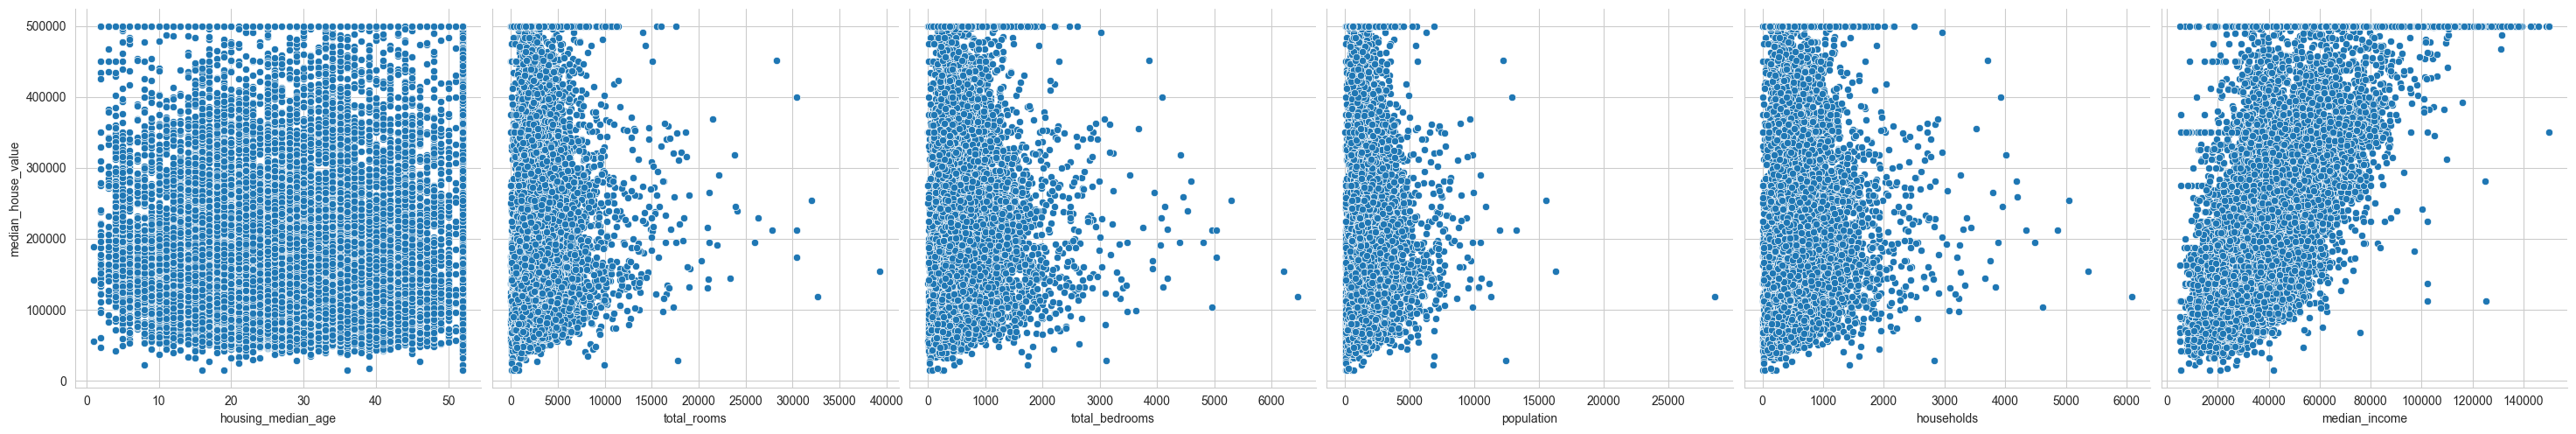

In [63]:
# for your convenience I have copied the feature names here.
# you could instead get them programmatically by slicing the housing.columns array

features = ['median_house_value', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population','households', 'median_income']

sns.pairplot(housing_train,
                y_vars = 'median_house_value',
                x_vars = ['housing_median_age', 'total_rooms', 'total_bedrooms', 'population','households', 'median_income'],
                height = 5,
                diag_kind = None)

plt.show()

##### c.

Do any of the previous relationships look linear? Notice anything else interesting about the data?


Also note that `median_house_value` seems to have been truncated at $\$500000$.  This is a real problem for linear regression!  It will severely bias our estimates.

The easiest way to deal with this is to discard all of these rows.

A more complicated way would be to try and utilize those rows using something like a [Tobit Model](https://en.wikipedia.org/wiki/Tobit_model).

Let's take the easy way out for now.  This gives us another independent test of our model:  after training our model on the rest of the data we can see whether it predicts that those rows have a median value above $\$500000$.

In [64]:
# Set aside all of the rows for which the median house value is 500000
housing_truncated = housing[housing['median_house_value'] == 500000]
housing_train_truncated = housing_train[housing_train['median_house_value'] == 500000]
housing_test_truncated = housing_test[housing_test['median_house_value'] == 500000]

# Redefine these to only include the non-truncated examples
housing = housing[housing['median_house_value'] < 500000]
housing_train = housing_train[housing_train['median_house_value'] < 500000]
housing_test = housing_test[housing_test['median_house_value'] < 500000]

##### d.

Another part of EDA is calculating descriptive statistics.

One statistic of interest to us in this situation is the <i>Pearson correlation coefficient</i>. For two variables $x$ and $y$ with $n$ observations each, the Pearson correlation is given by:

$$
r = \frac{\sum_{i=1}^n \left( x_i - \overline{x} \right) \left( y_i - \overline{y}  \right)}{\sqrt{\sum_{i=1}^n \left(x_i - \overline{x}\right)^2 \sum_{i=1}^n \left(y_i - \overline{y} \right)^2}} = \frac{\text{cov}\left(x, y\right)}{\sigma_x \sigma_y},
$$

where $x_i$ is the $i^\text{th}$ observation, $\overline{x} = \sum_{i=1}^n x_i/n$, $\text{cov}\left( x, y \right)$ is the covariance between $x$ and $y$, and $\sigma_x$ denotes the standard deviation of $x$.

$r \in [-1,1]$ gives a sense of the strength of the linear relationship between $x$ and $y$. The closer $|r|$ is to $1$, the stronger the linear relationship between $x$ and $y$, the sign of $r$ determines the direction of the relationship, with $r < 0$ meaning a line with a negative slope and $r > 0$ a line with a positive slope.

Calculate the correlation between `median_house_value` and the columns you have previously plotted.

<i>Hint: Either <a href="https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.corr.html">https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.corr.html</a> or <a href="https://numpy.org/doc/stable/reference/generated/numpy.corrcoef.html">https://numpy.org/doc/stable/reference/generated/numpy.corrcoef.html</a> should work.</i>.

In [65]:
for f in features:
    if f != 'median_house_value':
        housing_correlation = housing[[f, 'median_house_value']]
        feature_corr = housing_correlation.corr()
        print('The correlation between median house value and', f, 'is: \n', feature_corr)

The correlation between median house value and housing_median_age is: 
                     housing_median_age  median_house_value
housing_median_age            1.000000            0.065761
median_house_value            0.065761            1.000000
The correlation between median house value and total_rooms is: 
                     total_rooms  median_house_value
total_rooms            1.000000            0.144051
median_house_value     0.144051            1.000000
The correlation between median house value and total_bedrooms is: 
                     total_bedrooms  median_house_value
total_bedrooms            1.000000            0.075219
median_house_value        0.075219            1.000000
The correlation between median house value and population is: 
                     population  median_house_value
population            1.000000            0.012789
median_house_value    0.012789            1.000000
The correlation between median house value and households is: 
                 

##### e.

Based on your EDA, which feature do you think would best predict `median_house_value` in a simple linear regression model?
(Median income, given r ~ 0.65)

WARNING:  while using feature/outcome correlation is a reasonable choice for feature selection in a simple linear regression model, it is **not** a good choice for multiple linear regression.  [This stats.stackexchange post](https://stats.stackexchange.com/a/139031/97124) explains why!

##### f.

We have not yet investigated *spatial* variation in the housing prices.

Use [https://plotly.com/python/mapbox-density-heatmaps/](https://plotly.com/python/mapbox-density-heatmaps/) as inspiration and make a heatmap of `median_house_value`.

Does it seem like including the latitude and longitude somehow in our model would be helpful?

In [66]:
fig = px.density_map(housing, lat='latitude', lon='longitude', z='median_house_value', radius=10,
                        center=dict(lat=np.mean(housing['latitude']), lon=np.mean(housing['longitude'])), zoom=0,
                        map_style="open-street-map")  # this last parameter lets us graph on top of an actual world map - frequently quite helpful, if our data is geotagged!
fig.show()
# requires a little zooming in
# lat/long heatmap suggests that prices are higher in the expected locations: near cities/towns and coasts. all of the data is in California.

#### 4. Modeling

Now you will build some preliminary models for this data set.

##### a.

When doing predictive modeling it is good practice to have a <i>baseline model</i> which is a simple "model" solely for comparison purposes. These are not, typically, complex or good models, but they are important reference points to give us a sense of how well our models are actually performing.

A standard regression model baseline is to just predict the average value of $Y$ for any value of $X$. In this setting that model looks like this:

$$
\text{Baseline Model: } \ \ \ \ \text{Median House Value} = \mathbb{E}\left(\text{Median House Value}\right) + \epsilon,
$$

where $\epsilon$ is i.i.d. and normally distributed.

Write some code to estimate $\mathbb{E}\left(\text{Median House Value}\right)$ using the training set.

In [67]:
class MeanRegressor():
    '''
    A model which learns the mean of the training targets.
    '''
    def __init__(self):
        self.training_mean = None

    def fit(self, X_train, y_train):
        '''
        X_train: the input data. Not used at all in .fit
        y_train: the training targets.
        training_mean: the mean of the training targets.
        '''
        if type(X_train).__module__ != np.__name__:
            raise TypeError("X_train is not a numpy array")
        if type(y_train).__module__ != np.__name__:
            raise TypeError("y_train is not a numpy array")
        if X_train.shape[0] != y_train.shape[0]:
            raise ValueError(f"X_train has {X_train.shape[0]} rows while y_train has {y_train.shape[0]}.")

        self.training_mean = y_train.mean()
        
    def predict(self, X_new):
        '''
        X_new: the new input data.
        preds: 
            The predicted outputs. 
            It is a one dimensional numpy array with as many entries as X_new has rows.
            Each entry should be equal to the training mean.
        '''
        if self.training_mean is None:
            raise Exception('You need to fit the model before prediction')
        preds = self.training_mean * np.ones(X_new.shape[0])
        return preds

Below you will use cross-validation to compare one simple linear regression models, one multiple linear regression model, and one kNN model which uses the spatial data.

$$
\begin{align*}
\text{Baseline Model}:& \ \text{Median House Value} = \mathbb{E}\left(\text{Median House Value}\right) + \epsilon\\

\text{SLR Model}:& \ \text{Median House Value} = \beta_0 + \beta_1 \left( \text{Median Income} \right) + \epsilon\\

\text{MLR model}:& \ \text{Median House Value} = \beta_0 + \beta_1 \left(\text{Median Income}\right)  + \beta_2 \left(\text{Households}\right) + \epsilon\\

\text{kNN model}:& \ \text{Use k nearest neighbors regression on latitude and longitude with $k = 10$}\\
\end{align*}
$$

We will attempt hyperparameter tuning on $k$ in a later problem session, but just stick with $k=10$ for now.

##### b.
In this problem practice fitting just the MLR model using the training set and `sklearn`'s `LinearRegression` model, <a href="https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html">https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html</a>.

In [68]:
# import the linear regression model
from sklearn.linear_model import LinearRegression

# instantiate a model object
mlr_model = LinearRegression()

# Fit the model to the training data
housing_train_X = housing_train[['median_income', 'households']]
housing_train_y = housing_train['median_house_value']

mlr_model.fit(housing_train_X, housing_train_y)


LinearRegression()

In [69]:
mlr_model.intercept_

np.float64(38146.113555130985)

In [70]:
mlr_model.coef_

array([ 3.95669021, 16.81549238])

##### c.

In this problem you will try to implement $5$-fold cross-validation (CV) to compare these three models and the baseline model to see which one has the lowest average cross-validation root mean squared error (RMSE).

Because this may be your first time implementing CV, some of the code will be filled in for you.

In [73]:
## import KFold and kNeighborsRegressor here
## import root_mean_squared_error
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import root_mean_squared_error 

In [76]:
## Make a KFold object
## remember to set a random_state and set shuffle = True
num_splits = 5
num_models = 4
kfold = KFold(num_splits, shuffle=True, random_state=518)

## This array will hold the mse for each model and split
rmses = np.zeros((num_models, num_splits))

## set a split counter
i = 0

## loop through the kfold here
for train_index, test_index in kfold.split(housing_train):
    ## cv training set
    housing_tt = housing_train.iloc[train_index]
    
    ## cv holdout set
    housing_ho = housing_train.iloc[test_index]
    
    ## "Fit" mean and get holdout root mean squared error for the baseline model.
    ## No need to use an sklearn function:  just get the mean.  
    ## baseline_pred should be a numpy array with the same number of elements as housing_ho

    baseline_pred = housing_tt.median_house_value.mean()*np.ones(len(housing_ho))
    rmses[0, i] = root_mean_squared_error(housing_ho.median_house_value, baseline_pred)
    
    ## Fit and get ho rmse for slr model
    slr = LinearRegression()
    slr.fit(housing_tt[['median_income']], housing_tt.median_house_value)
    rmses[1, i] = root_mean_squared_error(housing_ho.median_house_value, slr.predict(housing_ho[['median_income']]))
    
    ## Fit and get ho mse for mlr model
    mlr = LinearRegression()
    mlr.fit(housing_tt[['median_income', 'households']], housing_tt.median_house_value)
    rmses[2, i] = root_mean_squared_error(housing_ho.median_house_value, mlr.predict(housing_ho[['median_income', 'households']])) 
    
    ## Fit and get ho rmse for the spatial model
    knn = KNeighborsRegressor()
    knn.fit(housing_tt[['latitude', 'longitude']], housing_tt.median_house_value)
    rmses[3, i] = root_mean_squared_error(housing_ho.median_house_value, knn.predict(housing_ho[['latitude', 'longitude']]))
    
    i = i + 1

In [77]:
## Find the avg cv mse for each model here
print(f"Baseline Avg. CV RMSE: {np.mean(rmses[0,:])} and STD: {np.std(rmses[0,:])}")
print(f"SLR Avg. CV MSE: {np.mean(rmses[1,:])} and STD: {np.std(rmses[1,:])}")
print(f"MLR Avg. CV MSE: {np.mean(rmses[2,:])} and STD: {np.std(rmses[2,:])}")
print(f"Spatial Avg. CV MSE: {np.mean(rmses[3,:])} and STD: {np.std(rmses[3,:])}")


Baseline Avg. CV RMSE: 96972.29593879313 and STD: 1014.520503022636
SLR Avg. CV MSE: 74240.8484743033 and STD: 338.8545517555276
MLR Avg. CV MSE: 73971.77807112625 and STD: 396.1346135989573
Spatial Avg. CV MSE: 48657.46721247876 and STD: 1092.7803042880182


##### d.

Which model had the lowest average cross validation root mean squared error?  k-NN/spatial data does the best here.

Discuss the meaning of the STD in this context. STD here means inter-run variability in the MSE for each class of model.

##### e.

Train the simple linear regression model on the full training set and predict on the truncated dataset.  Does the model predict that the median house values are in excess of $\$500000$?

In [79]:
slr = LinearRegression()
slr.fit(housing_train[['median_income']], housing_train.median_house_value)
slr.predict(housing_train_truncated[['median_income']])  # predicted median house values are well below $500k... not ideal!

array([124976.97166344, 187987.32852804, 174040.23067667,  96220.2737567 ,
       246100.89868621, 194195.75453085, 149667.58775143, 220802.15892445,
       189998.50878248, 273446.59068322, 192232.27025084, 315279.93490829,
       203695.20276818, 139464.6238915 , 156082.69631003, 189485.77705753,
       278069.12553678, 227260.98879293, 249240.88366843, 210535.60043197,
       166782.49323676])

That's it for this notebook. In the next couple of regression based notebooks we will build additional models for this data set.

--------------------------

This notebook was written for the Erdős Institute Data Science Boot Camp by Steven Gubkin.

Please refer to the license in this repo for information on redistribution.